(2348679, 5)
(587170, 5)
(2348679,)
(587170,)
                                date  date_block_num       shop_id  \
count                        2935849    2.935849e+06  2.935849e+06   
mean   2014-04-03 05:44:34.970681344    1.456991e+01  3.300173e+01   
min              2013-01-01 00:00:00    0.000000e+00  0.000000e+00   
25%              2013-08-01 00:00:00    7.000000e+00  2.200000e+01   
50%              2014-03-04 00:00:00    1.400000e+01  3.100000e+01   
75%              2014-12-05 00:00:00    2.300000e+01  4.700000e+01   
max              2015-10-31 00:00:00    3.300000e+01  5.900000e+01   
std                              NaN    9.422988e+00  1.622697e+01   

            item_id    item_price  item_cnt_day  
count  2.935849e+06  2.935849e+06  2.935849e+06  
mean   1.019723e+04  8.908532e+02  1.242641e+00  
min    0.000000e+00 -1.000000e+00 -2.200000e+01  
25%    4.476000e+03  2.490000e+02  1.000000e+00  
50%    9.343000e+03  3.990000e+02  1.000000e+00  
75%    1.568400e+04  9.

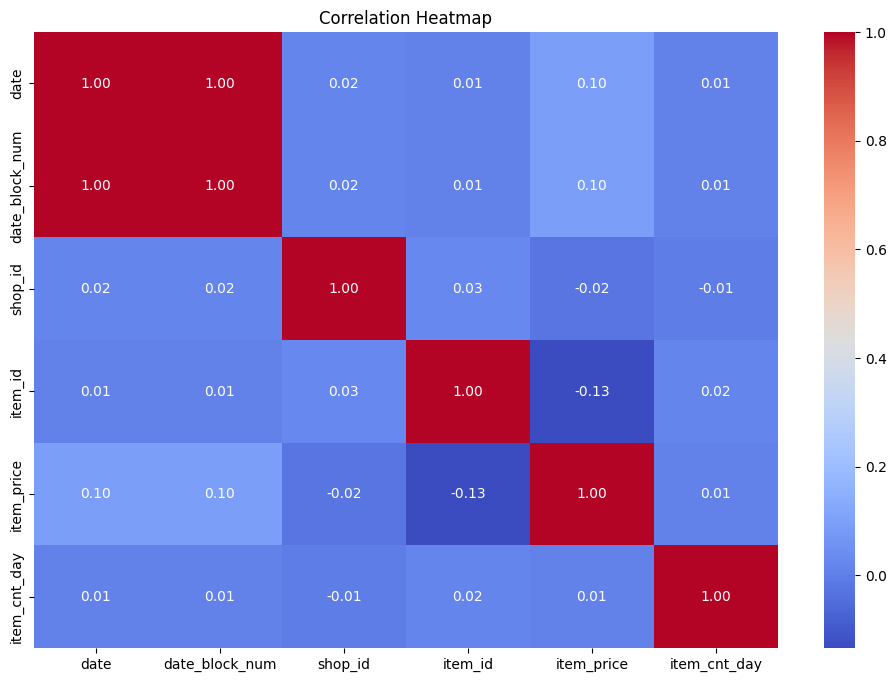

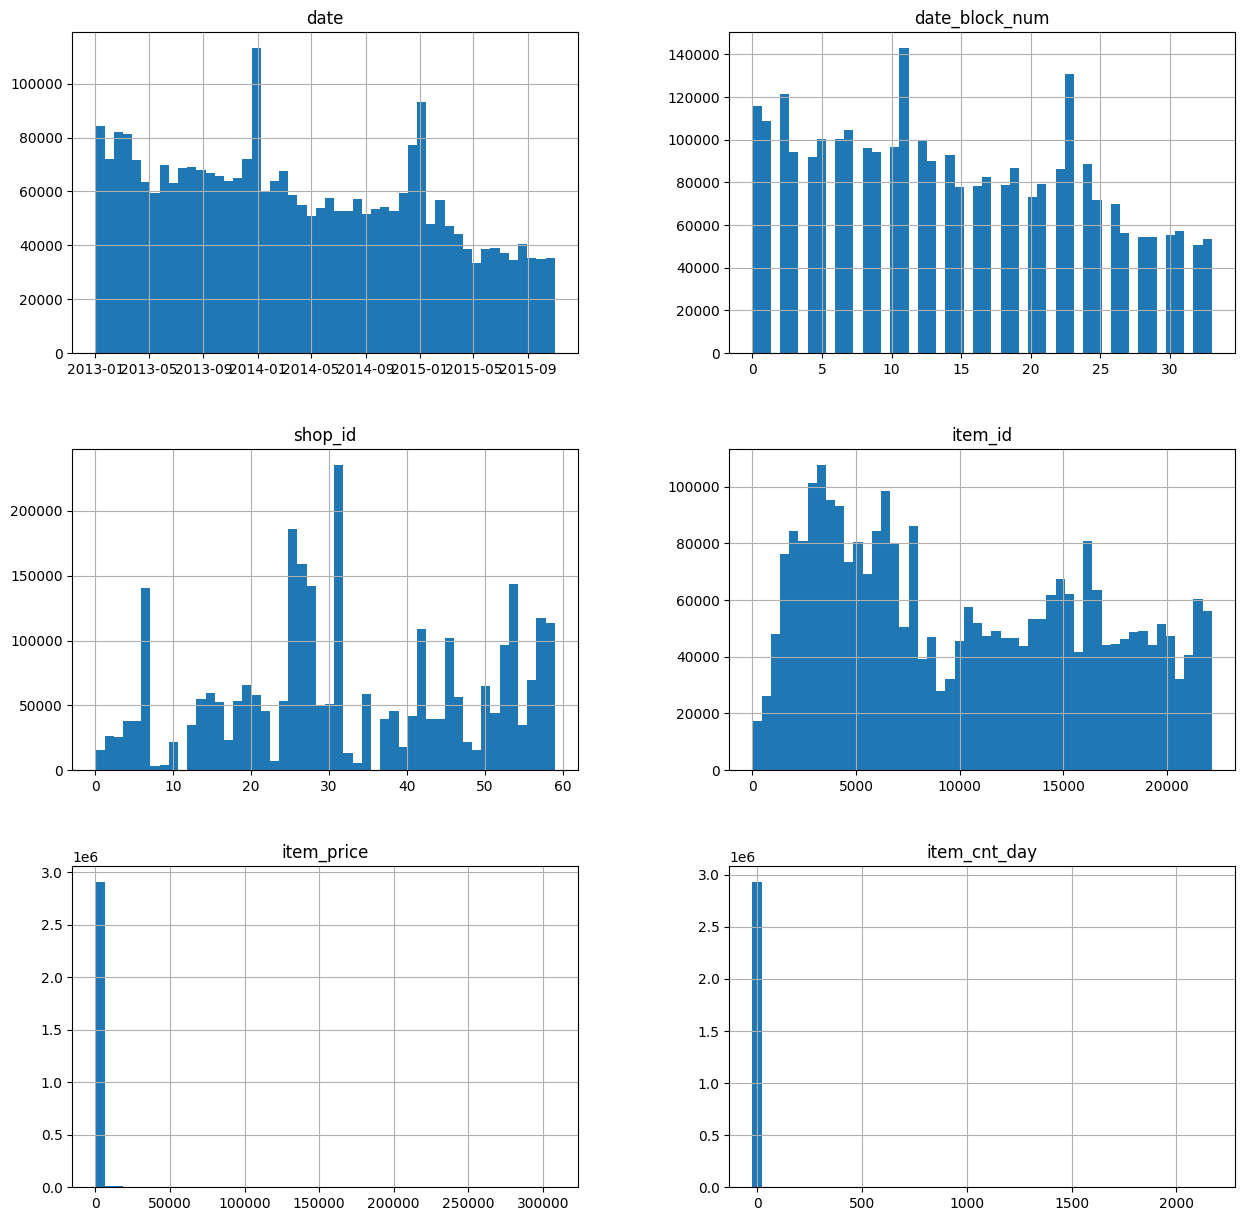

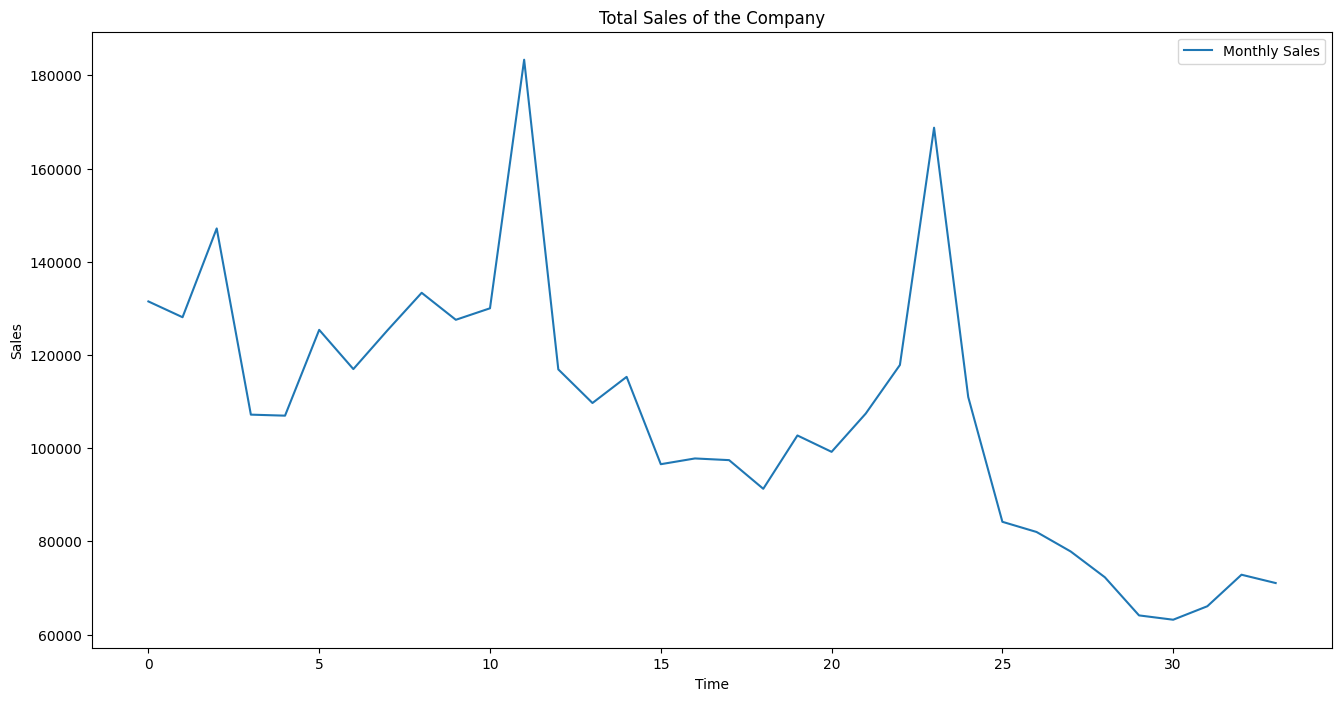

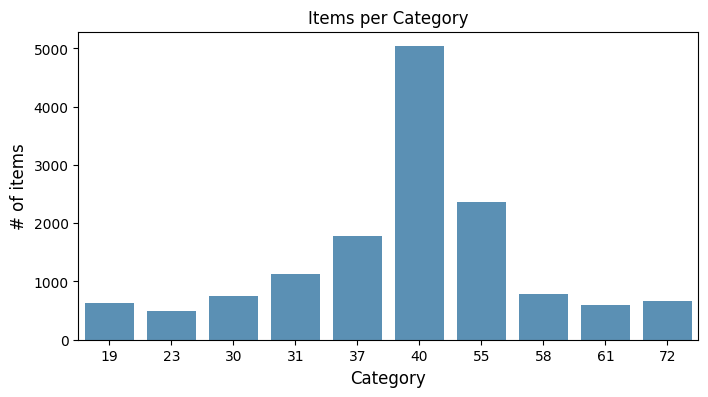

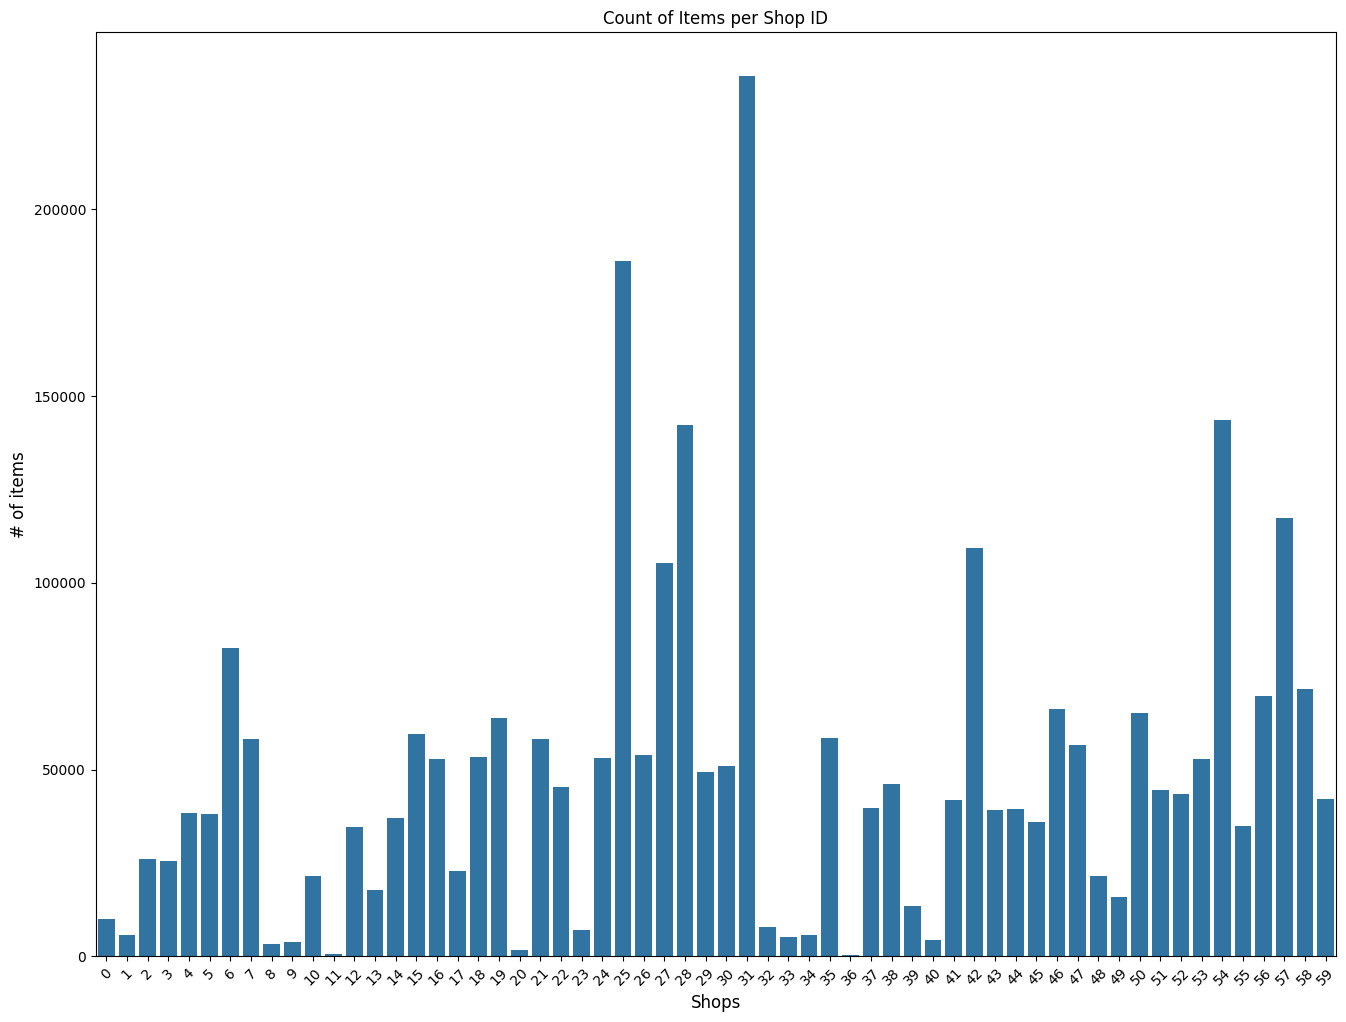

[]

<Figure size 1600x1200 with 0 Axes>

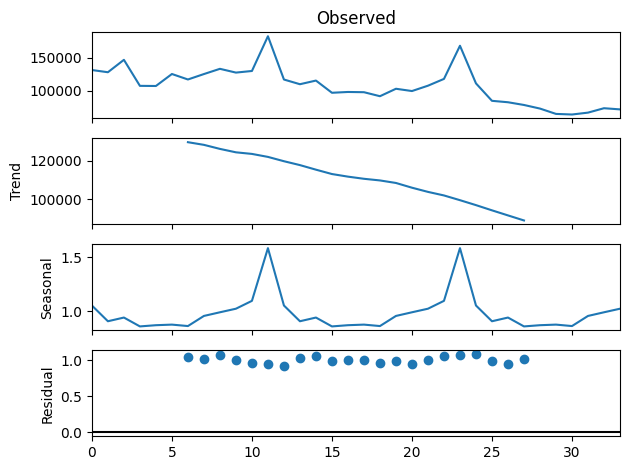

<Figure size 1600x1200 with 0 Axes>

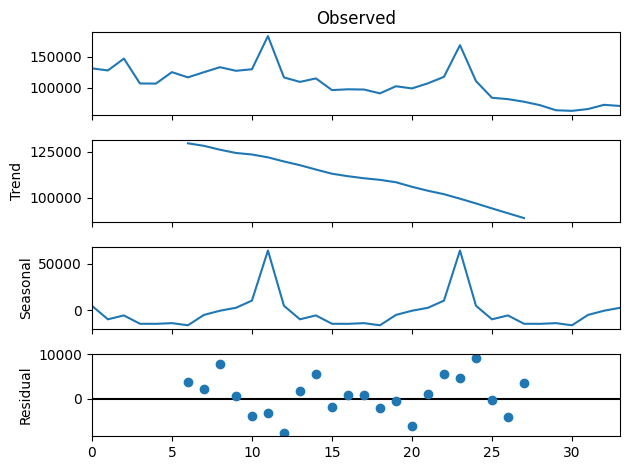

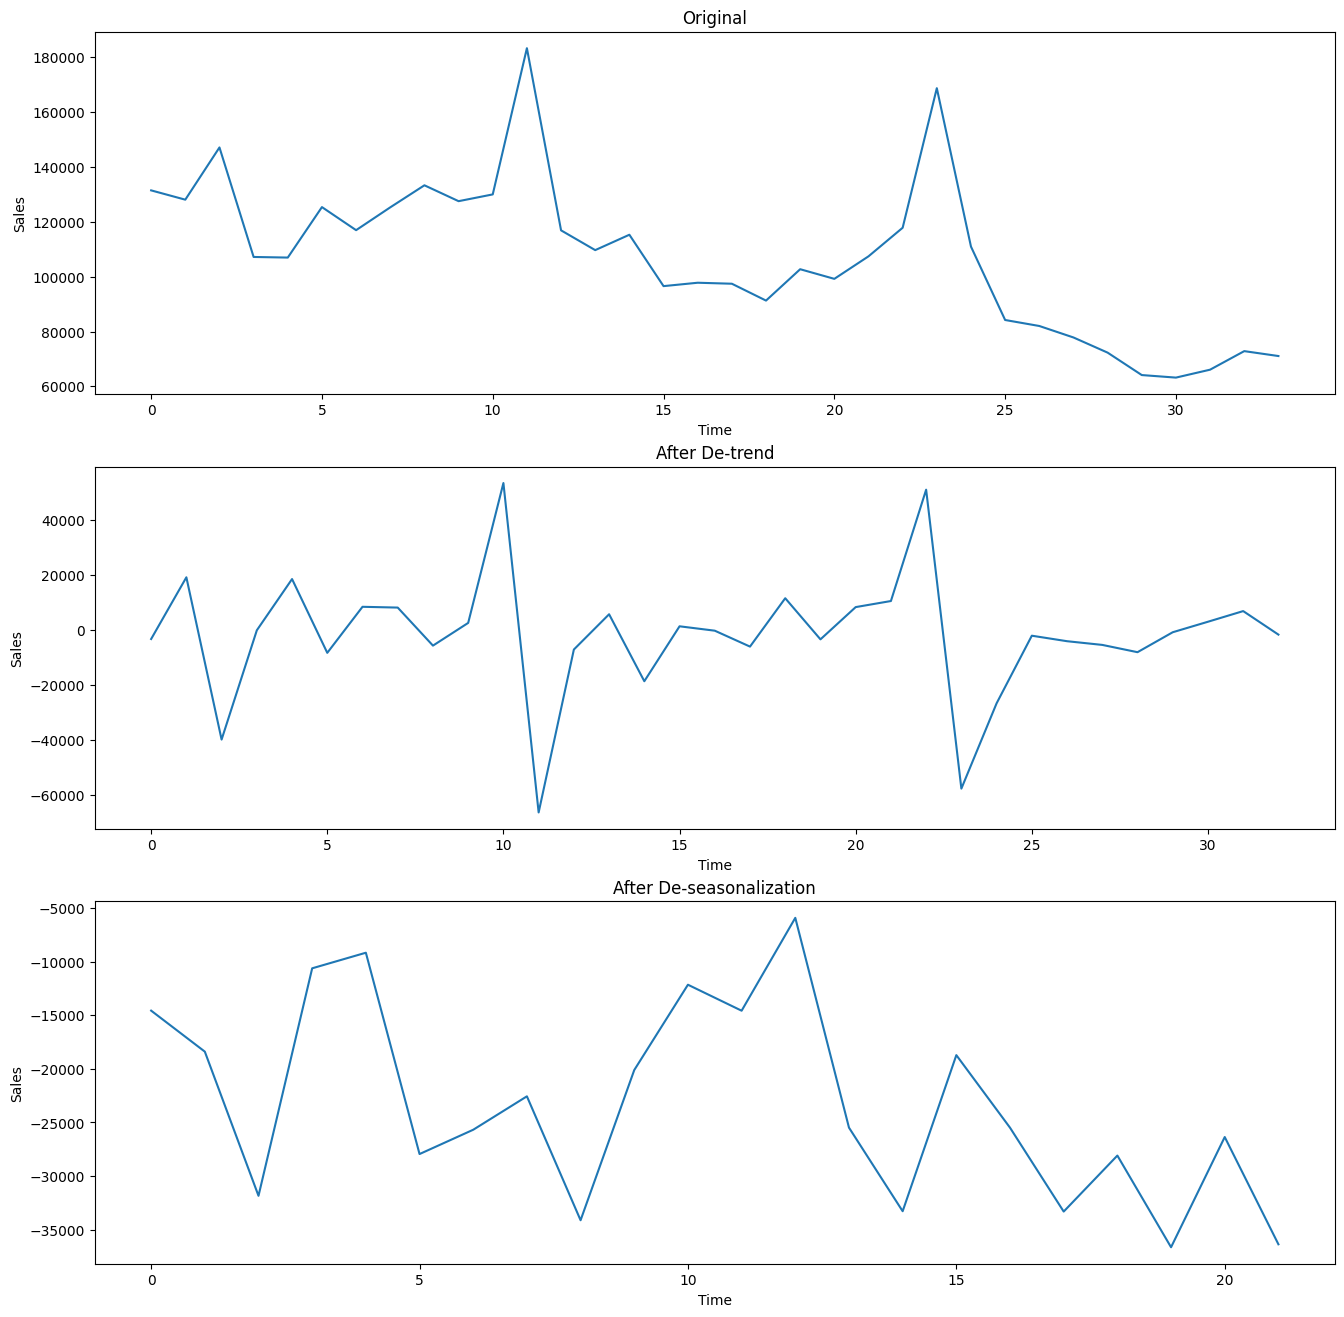

In [10]:
#https://www.kaggle.com/code/ashioyajotham/predict-future-sales

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

train = pd.read_csv("sales_train.csv")
categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
test = pd.read_csv("test.csv")

#Normalize dates
train.date = train.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

#Train Test Split
independent = [i for i in train.columns if i != 'item_cnt_day']
dependent = 'item_cnt_day'
X = train[independent]
y = train[dependent]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Descriptive Statistics
print(train.describe())

#Heat Map
correlation_matrix = train.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

#Histogram
hist = train[train.columns].hist(bins=50, figsize=(15, 15))
plt.show()

#Visualization
#Monthly sales over time
ts = train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts = ts.astype('float')
plt.figure(figsize=(16, 8))
plt.title('Total Sales of the Company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts, label='Monthly Sales')
plt.legend()
plt.show()

monthly_sales = train.groupby(["date_block_num", "shop_id", "item_id"]).agg({
    "date": ["min", "max"],
    "item_price": "mean",
    "item_cnt_day": "sum"
})

#Number of Items per Category
x = items.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id',ascending=False)
x = x.iloc[0:10].reset_index()
plt.figure(figsize=(8,4))
ax = sns.barplot(x="item_category_id", y="item_id", data=x, alpha=0.8)
plt.title("Items per Category")
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.show()

#Number of Items per Shop
count = train.groupby(['shop_id'])['item_id'].sum().reset_index()
plt.figure(figsize=(16,12))
ax = sns.barplot(x='shop_id', y='item_id', data=count)
plt.title('Count of Items per Shop ID')
plt.ylabel('# of items', fontsize=12)
plt.xlabel('Shops', fontsize=12)
plt.xticks(rotation=45)
plt.show()

#Time Series
import statsmodels.api as sm
#Multiplicative
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="multiplicative")
plt.figure(figsize=(16,12))
fig = res.plot()
fig.show()

#Additive
res = sm.tsa.seasonal_decompose(ts.values,period=12,model="additive")
plt.figure(figsize=(16,12))
fig = res.plot()
fig.show()

from pandas import Series as Series
#Differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

#Invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

#De-trend
ts=train.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts = difference(ts)
plt.plot(new_ts)
plt.plot()

#Deseasonalization
plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)
plt.plot(new_ts)
plt.plot()

#Test stationarity
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(new_ts)

#Differenced series is stationary, so apply ARIMA model
from statsmodels.tsa.arima.model import ARIMA

#Aggregate to months
ts = train.groupby(['date']).agg({'item_cnt_day':'sum'})
ts.columns = ['item_cnt_month']
ts.index = pd.to_datetime(ts.index)
ts = ts.resample('M').sum()

# Fit model
model = ARIMA(ts, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

# Create future dates for forecasting
last_date = ts.index[-1]
future_dates = pd.date_range(start=last_date, periods=7, freq='M')[1:]  # Exclude the last known date

# Generate forecast
forecast = model_fit.forecast(steps=6)
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['item_cnt_month'])

# Plot both original data and forecast
plt.figure(figsize=(16,6))
plt.plot(ts.index, ts['item_cnt_month'], label='Original', color='blue')
plt.plot(forecast_df.index, forecast_df['item_cnt_month'], label='Forecast', color='red')
plt.legend(loc='best')
plt.title('Sales Forecast')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.show()

#test['date_block_num'] = 34  # This is the month we're predicting for
#test = test.merge(items, on='item_id', how='left')
#test = test.merge(item_cats, on='item_category_id', how='left')
#test = test.merge(shops, on='shop_id', how='left')

# Create predictions
# We'll use the mean of the last 3 months for each shop-item pair as our prediction
# First, get the last 3 months of data
last_3_months = train[train.date_block_num >= 31]  # 31,32,33 are the last 3 months

# Calculate mean sales for each shop-item pair
shop_item_means = last_3_months.groupby(['shop_id', 'item_id'])['item_cnt_day'].agg('mean').reset_index()
shop_item_means.columns = ['shop_id', 'item_id', 'item_cnt_month']

# Merge predictions with test data
submission = test.merge(shop_item_means, on=['shop_id', 'item_id'], how='left')

# Fill missing values with 0 (for shop-item pairs that haven't been sold before)
submission['item_cnt_month'] = submission['item_cnt_month'].fillna(0)

# Clip the predictions to the required range [0,20]
submission['item_cnt_month'] = submission['item_cnt_month'].clip(0, 20)

# Prepare submission file
submission_file = submission[['ID', 'item_cnt_month']]
print("\nSubmission file shape:", submission_file.shape)
print("\nSubmission sample:")
print(submission_file.head())

# Save to CSV
submission_file.to_csv('submission.csv', index=False)
print("\nSubmission file has been saved as 'submission.csv'")

# Basic statistics of our predictions
print("\nPrediction statistics:")
print(submission_file['item_cnt_month'].describe())